In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
pd.set_option('display.max_colwidth',None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#### Loading all the Data files

In [12]:
users_df = pd.read_csv("C:\\Users\\amith\\OneDrive\\Desktop\\users.csv",sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv("C:\\Users\\amith\\OneDrive\\Desktop\\ratings.csv",sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("C:\\Users\\amith\\OneDrive\\Desktop\\books.csv",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

#### List down all the loaded files to check the shape and data

In [13]:
print("Books dataframe shape: " , books_df.shape)
print("Ratings dataframe shape: " , ratings_df.shape)
print("Users dataframe shape: " , users_df.shape)

Books dataframe shape:  (271360, 8)
Ratings dataframe shape:  (1149780, 3)
Users dataframe shape:  (278858, 3)


In [14]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [15]:
ratings_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [16]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [17]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
# Getting the indices of location which is not equal to 3
drop_indeces = users_df[users_df['Location'].str.split(",").str.len() != 3].index

In [19]:
## Dropping the above indices
users_df = users_df.drop(index = drop_indeces)


In [20]:
## Computing the count whose location has all 3 values
(users_df['Location'].str.split(",").str.len()==3).value_counts()

Location
True    277348
Name: count, dtype: int64

In [21]:
users_df[['City','State','Country']] = users_df['Location'].str.strip().str.split(",",expand = True,n=2)

In [22]:
users_df['City'] = users_df['City'].str.strip()
users_df['State'] = users_df['State'].str.strip()
users_df['Country'] = users_df['Country'].str.strip()

In [23]:
users_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


In [24]:
users_df = users_df.drop('Location',axis = 1)
users_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [25]:
users_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [26]:
users_df[~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

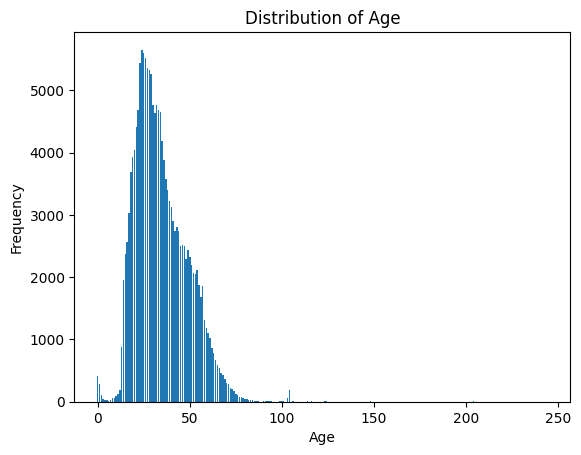

In [27]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

In [28]:
users_to_omit = ~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()
users_df.loc[users_to_omit] = np.nan
users_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

In [29]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [30]:
users_df['Age'].mean()

np.float64(34.729518290474466)

#### Imputing age column with the mean age value of 34

In [31]:
null_age = users_df['Age'].isnull()
users_df.loc[null_age,'Age'] = users_df['Age'].mean()

<BarContainer object of 82 artists>

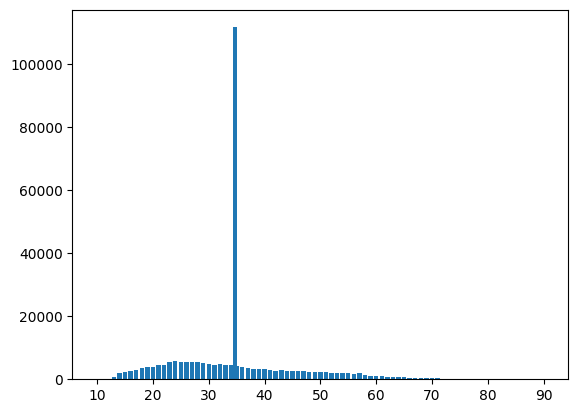

In [32]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)


In [33]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [34]:
users_df['Age'] = users_df['Age'].astype('int')

In [35]:
users_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

In [36]:
users_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

In [38]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [39]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [40]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

In [41]:
users_df = users_df[users_df['Country'].isin(list_of_countries)]
users_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


In [42]:
list_of_states = users_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [43]:
users_df = users_df[users_df['State'].isin(list_of_states)]

In [44]:
list_of_city = users_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_df = users_df[users_df['City'].isin(list_of_city)]

In [45]:
print("Unique country count: " , users_df['Country'].nunique())
print("Unique state count: " ,users_df['State'].nunique())
print("Unique City count: " , users_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


In [46]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [47]:
books_df = books_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [48]:
books_df['Year-Of-Publication'].unique()


array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [49]:
year_of_publication = books_df['Year-Of-Publication'].str.extract(r'(\d{4})')[0]
books_df = books_df[books_df['Year-Of-Publication'].isin(year_of_publication)]

In [50]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')

C:\Users\amith\AppData\Local\Temp\ipykernel_10200\406188384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')


In [51]:
books_df['Year-Of-Publication'].unique()


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

In [52]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [53]:
sorted(ratings_df['Book-Rating'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10)]

Text(0, 0.5, 'Frequency')

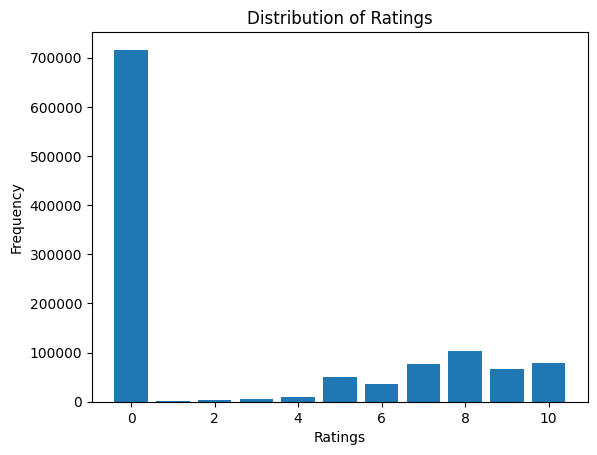

In [54]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

In [55]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [56]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [57]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int64  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.2+ MB


In [58]:
dataset = ratings_df.merge(books_df,on = 'ISBN').merge(users_df,how='inner',on='User-ID')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int64 
 6   Publisher            132920 non-null  object
 7   Age                  132920 non-null  int64 
 8   City                 132920 non-null  object
 9   State                132920 non-null  object
 10  Country              132920 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.2+ MB


In [59]:
dataset = dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,276774,0099543818,0,"East, West",Salman Rushdie,1995,Vintage Books,28,bern,bern,switzerland
1,276774,3404147723,0,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,Patrice Leavold,2002,LÃ?Â¼bbe,28,bern,bern,switzerland
2,276774,3423111321,0,Die Teufelin. Roman.,Fay Weldon,1989,Dtv,28,bern,bern,switzerland
3,276774,3442136644,9,Endlich Nichtraucher.,Allen Carr,1992,Goldmann,28,bern,bern,switzerland
4,276774,3492232000,0,Ein Liebhaber zuviel ist noch zu wenig.,Gaby Hauptmann,2000,Piper,28,bern,bern,switzerland


In [60]:
dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].sample(10)

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
117644,9,Wally Lamb,1998,Pocket,24,puchong,selangor,malaysia
125314,0,Stephen King,2000,Pocket,32,barcelona,catalonia,spain
60247,7,Christian Jacq,1995,Planeta Pub Corp,35,barcelona,barcelona,spain
38952,0,Zoe Barnes,2003,Piatkus Books,34,firenze,toscana,italy
103375,10,Barbara Cleverly,2003,Goldmann,34,achim,niedersachsen,germany
13408,0,Jessica Anderson,1990,Penguin USA,40,melbourne,victoria,australia
89452,0,Mary Kingsley,1997,Topaz,34,ginsheim,hessen,germany
55047,0,MICHAEL CRICHTON,1988,Ballantine Books,28,london,ontario,canada
18885,0,J. R. R. Tolkien,1992,Del Rey Books,23,helsinki,uusimaa,finland
101684,0,Claire H. Blatchford,1983,Cook Communications Ministries intl,22,dunedin,otago,new zealand


In [61]:
recomendation_dataset = dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int64 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int64 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.1+ MB


In [62]:
encoder = LabelEncoder()
for column in recomendation_dataset.columns:
    if recomendation_dataset[column].dtype == object:
        recomendation_dataset[column] = encoder.fit_transform(recomendation_dataset[column])


In [63]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,27839,1995,6288,28,261,81,79
1,0,23900,2002,3634,28,261,81,79
2,0,9455,1989,1697,28,261,81,79
3,9,1009,1992,2420,28,261,81,79
4,0,10235,2000,4671,28,261,81,79
...,...,...,...,...,...,...,...,...
132915,0,21284,1997,3025,30,2545,496,16
132916,0,15027,2000,1328,30,2545,496,16
132917,5,15481,1999,5995,34,1830,264,87
132918,5,21118,2000,5995,34,1830,264,87


In [64]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [65]:
for column in recomendation_dataset.columns:
    min = recomendation_dataset[column].min()
    max = recomendation_dataset[column].max()
    recomendation_dataset[column] = recomendation_dataset[column].apply(normalizer,args=(min,max))


In [66]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132
...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044


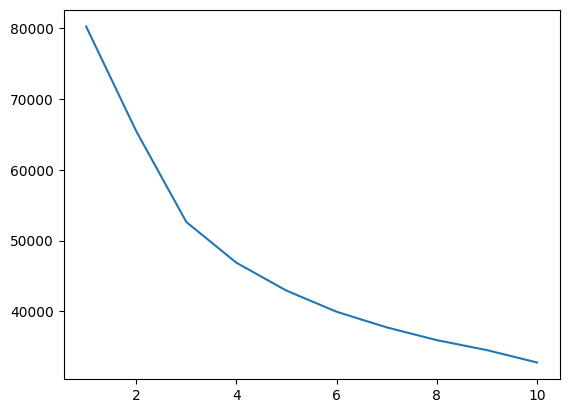

In [67]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)


In [68]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_dataset)


In [69]:
recomendation_dataset['Clusters'] = clusters

In [70]:
recomendation_dataset['Clusters'].value_counts()

Clusters
1    35912
2    26483
3    26165
0    26054
4    18306
Name: count, dtype: int64

In [71]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132,2
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132,2
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132,2
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132,0
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132,2
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824,1
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824,1
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044,0
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044,0


In [72]:
train_df,test_df = recomendation_dataset.iloc[:,:-1],recomendation_dataset.iloc[:,-1]

In [73]:
train_X,test_x,train_y,test_y = train_test_split(train_df,test_df,test_size=0.2)

In [74]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(train_X,train_y)

NearestCentroid()

In [75]:
print(cross_val_score(rocchio_clf,train_df,test_df,cv = 5))

[0.99556124 0.99695305 0.99695305 0.99778062 0.99781824]


In [76]:
pred_y = rocchio_clf.predict(test_x)

In [77]:
accuracy_score(test_y,pred_y) * 100

99.93981342160698

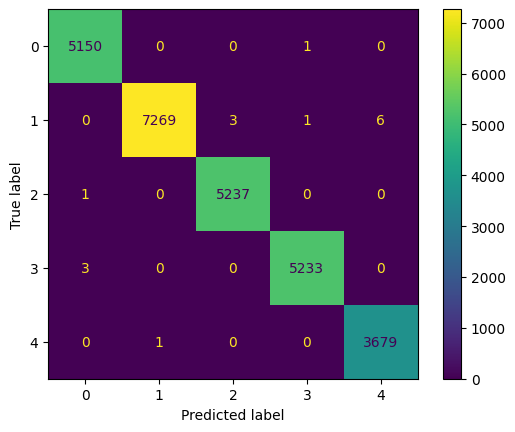

In [78]:
cm = confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [79]:
samples = test_x.sample(10)
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
50261,0.5,0.491518,0.668919,0.317482,0.3750,0.080096,0.099075,0.197802
104141,0.5,0.547982,0.594595,0.025572,0.3000,0.970093,0.655218,0.175824
14491,0.7,0.785782,0.628378,0.800508,0.3000,0.673084,0.655218,0.175824
121771,0.0,0.250916,0.635135,0.817257,0.1875,0.388106,0.931308,0.054945
125596,0.0,0.077245,0.587838,0.422761,0.1625,0.963218,0.968296,0.065934
130288,0.0,0.800622,0.689189,0.892627,0.0750,0.334823,0.689564,0.549451
4456,0.0,0.393892,0.614865,0.077912,0.4750,0.119972,0.128137,0.351648
9565,0.5,0.944891,0.662162,0.422761,0.4000,0.609144,0.096433,0.351648
104512,0.3,0.782796,0.581081,0.097802,0.2250,0.525610,0.261559,0.956044
84518,0.8,0.053908,0.655405,0.508748,0.2500,0.844620,0.261559,0.956044


In [80]:
indeces = samples.index.tolist()
indeces

[50261, 104141, 14491, 121771, 125596, 130288, 4456, 9565, 104512, 84518]

In [81]:
samples_pred = rocchio_clf.predict(samples).reshape(1,-1).flatten().tolist()
samples_pred

[4, 3, 3, 1, 1, 2, 4, 0, 2, 0]

In [82]:
data = train_X.copy()

In [83]:
data['Clusters'] = train_y

In [84]:
data

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
102826,1.0,0.991503,0.635135,0.662629,0.5875,0.304572,0.846764,0.956044,0
98239,0.0,0.876759,0.641892,0.096755,0.3625,0.143004,0.655218,0.175824,4
120579,0.0,0.145254,0.648649,0.654105,0.1875,0.158474,0.158520,0.956044,2
102863,0.0,0.553616,0.628378,0.036190,0.5875,0.304572,0.846764,0.956044,2
14415,0.0,0.563437,0.560811,0.843876,0.3250,0.269165,0.019815,0.175824,4
...,...,...,...,...,...,...,...,...,...
121371,0.0,0.452141,0.668919,0.394497,0.3625,0.874871,0.655218,0.175824,1
93148,1.0,0.763646,0.621622,0.211904,0.4875,0.673084,0.655218,0.175824,3
42932,0.0,0.413349,0.587838,0.746074,0.2500,0.342729,0.792602,0.956044,2
117546,0.0,0.529571,0.533784,0.066397,0.3000,0.377449,0.655218,0.175824,1


In [85]:
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
50261,0.5,0.491518,0.668919,0.317482,0.3750,0.080096,0.099075,0.197802
104141,0.5,0.547982,0.594595,0.025572,0.3000,0.970093,0.655218,0.175824
14491,0.7,0.785782,0.628378,0.800508,0.3000,0.673084,0.655218,0.175824
121771,0.0,0.250916,0.635135,0.817257,0.1875,0.388106,0.931308,0.054945
125596,0.0,0.077245,0.587838,0.422761,0.1625,0.963218,0.968296,0.065934
130288,0.0,0.800622,0.689189,0.892627,0.0750,0.334823,0.689564,0.549451
4456,0.0,0.393892,0.614865,0.077912,0.4750,0.119972,0.128137,0.351648
9565,0.5,0.944891,0.662162,0.422761,0.4000,0.609144,0.096433,0.351648
104512,0.3,0.782796,0.581081,0.097802,0.2250,0.525610,0.261559,0.956044
84518,0.8,0.053908,0.655405,0.508748,0.2500,0.844620,0.261559,0.956044


In [86]:
books_rate_df = dataset.groupby('Book-Title')

In [87]:
def popular_books():
    return books_rate_df.size().sort_values(ascending=False).head(10).index

In [88]:
print('------- Here are some of the popular books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(popular_books())


------- Here are some of the popular books you may like -------
-----Happy Reading!!!-------


0                                Wild Animus
1                  The Lovely Bones: A Novel
2                      Bridget Jones's Diary
3                                 Life of Pi
4                                   Chocolat
5    The Girls' Guide to Hunting and Fishing
6                          The Da Vinci Code
7                                About a Boy
8                          The Joy Luck Club
9                     Snow Falling on Cedars
Name: Book-Title, dtype: object

In [89]:
def highest_rated_books():
    return books_rate_df['Book-Rating'].mean().sort_values(ascending=False).head(10).index

In [90]:
print('------- Here are some of the highest rated books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(highest_rated_books())


------- Here are some of the highest rated books you may like -------
-----Happy Reading!!!-------


0                                                 1,001 Things Everyone Should Know About American History
1    1,001 Computer Hints &amp; Tips: An A-To-Z Guide to Making the Most of Your Computer and the Internet
2                                                                              10 Real SATs, Third Edition
3                                        Zoltan Szabo Paints Landscapes: Advanced Techniques in Watercolor
4          Zolar's Magick of Color : Use the Power of Color to Transform Your Luck, Prosperity, or Romance
5                                                                                          Ã?Â?. Kolumnen.
6                                                 Zolar's Encyclopedia of Ancient and Forbidden Knowledge.
7                                                        Zombification: Stories from National Public Radio
8                                              Ziegen. Halten und ZÃ?Â¼chten von Milch- und Fleischziegen.
9                                    

In [91]:
for i in range(len(indeces)):
    knn_dataset = data[data['Clusters']==samples_pred[i]]
    knn_dataset = knn_dataset.reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:,1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(samples.loc[indeces[i]]).T,5,return_distance = False)
    print("\n------------Your Review-------------\n")
    display(pd.DataFrame(dataset.loc[indeces[i],'ISBN':]).T)
    print(f"\n------------Here are few recomendations based on your review that you may like-------------\n")
    recomendations = pd.DataFrame(columns = dataset.columns)
    
    for j in neighbors:
        display(pd.DataFrame(dataset.loc[knn_dataset.loc[j]['index'],['Book-Title','Book-Author','Year-Of-Publication','Publisher','City','State','Country']]))
    print("\n------------End-------------\n")
    


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
50261,0374100128,5,The Corrections (Oprah Edition),Jonathan Franzen,2001,Farrar Straus Giroux,40,beijing,beijing,china



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
26414,The Deep Blue Good-By,John D. MacDonald,1995,Fawcett Books,calgary,alberta,canada
18296,Chicken Soup for the Teenage Soul II (Chicken Soup for the Soul Series),Jack Canfield,1998,HCI Teens,calgary,alberta,canada
87065,Luke (Harlequin Temptation),Jill Shalvis,2003,Harlequin,calgary,alberta,canada
2303,The Painter of Birds,Lidia Jorge,2001,Harcourt,calgary,alberta,canada
92281,Die Bruderschaft,John Grisham,2003,Distribooks Inc,berlin,berlin,germany



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
104141,0920470246,5,Silica: The Forgotten Nutrient,Klaus Kaufmann,1990,Alive Books,34,windsor,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
120082,The Laughing Corpse (Anita Blake Vampire Hunter (Paperback)),Laurell K. Hamilton,1994,Ace Books,toronto,ontario,canada
84318,"Like Water for Chocolate: A Novel in Monthly Installments With Recipes, Romances and Home Remedies",Laura Esquivel,1994,Anchor Books/Doubleday,toronto,ontario,canada
30566,Come Love a Stranger,Kathleen E. Woodiwiss,1986,Avon,waterloo,ontario,canada
53195,"20,000 Leagues Under the Sea (Bantam Classics)",Jules Verne,1985,Bantam,toronto,ontario,canada
3389,The Vor Game,Lois McMaster Bujold,1990,Baen,waterloo,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
14491,0771056265,7,The Night They Stole the Stanley Cup (#2) (Screech Owls),ROY MACGREGOR,1995,Screech Owls,34,ottawa,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
28199,"Beware, the Snowman (Goosebumps, No 51)",R. L. Stine,1997,Scholastic,ottawa,ontario,canada
28201,BAD DREAMS (FEAR STREET ) : BAD DREAMS,R.L. Stine,1994,Simon Pulse,ottawa,ontario,canada
106466,Giant Bones,Peter S. Beagle,1997,Roc,ottawa,ontario,canada
61334,The Fisher King : A Novel,Paule Marshall,2000,Scribner,oshawa,ontario,canada
59268,The Practical Guide to Practically Everything,Peter Bernstein,1995,Random House,orleans,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
121771,0451526406,0,The Complete Poetry of Edgar Allan Poe,Edgar Allan Poe,1996,Signet Classics,25,hawthorn,victoria,australia



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
57995,"The Initiation (Nightmare Hall, No 14)",Diane Hoh,1994,Scholastic Paperbacks (Mm),geelong,victoria,australia
58026,"Station Rage (Star Trek Deep Space Nine, No 13)",Diane Carey,1995,Star Trek,geelong,victoria,australia
58014,Thigmoo,Eugene Byrne,1999,Simon &amp; Schuster (Trade Division),geelong,victoria,australia
58021,"Doctor's Orders (Star Trek, Book 50)",Diane Duane,1990,Star Trek,geelong,victoria,australia
58022,"DANGER ZONE HARDY BOYS CASEFILES #37 (Hardy Boys Casefiles, No 37)",Franklin W. Dixon,1990,Simon Pulse,geelong,victoria,australia



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
125596,3453032780,0,Die Herrin von Hay. Roman.,Barbara Erskine,1989,Heyne,23,wien,wien,austria



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
58735,Der Keltische Ring.,BjÃ?Â¶rn Larsson,2000,Goldmann,wien,wien,austria
44711,Judas Child,Carol O'Connell,1998,Hutchinson,wangaratta,victoria,australia
125592,Sex and the City.,Candace Bushnell,2001,Goldmann,wien,wien,austria
107798,Sex and the City.,Candace Bushnell,2001,Goldmann,wien,wien,austria
2091,The Time Traveler's Wife (Harvest Book),Audrey Niffenegger,2004,Harvest Books,vienna,vienna,austria



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
130288,0971880107,0,Wild Animus,Rich Shapero,2004,Too Far,16,georgetown,penang,malaysia



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
130228,Hidden Charges,Ridley Pearson,1993,St. Martin's Press,georgetown,penang,malaysia
106376,Wild Animus,Rich Shapero,2004,Too Far,dunedin,otago,new zealand
101695,Wild Animus,Rich Shapero,2004,Too Far,dunedin,otago,new zealand
39835,Wild Animus,Rich Shapero,2004,Too Far,dunedin,otago,new zealand
81973,The Collected Strange Stories of Robert Aickman,Robert Aickman,2000,Tartarus Pr,dunedin,otago,new zealand



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
4456,0553561227,0,The Ugly Little Boy,Isaac Asimov,1993,Bantam Books,48,bremen,bremen,germany



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
98913,The French Quarter Killers,John Dillmann,1989,Berkley Pub Group,berlin,berlin,germany
4471,Generation Golf: Eine Inspektion,Florian Illies,2000,Argon,bremen,bremen,germany
39500,Die Truhen des Arcimboldo. Nach den TagebÃ?Â¼chern des Heinrich Wilhelm Lehmann.,Hanjo Lehmann,1999,Aufbau Tb,berlin,berlin,germany
70663,The French Quarter Killers,John Dillmann,1989,Berkley Pub Group,berlin,berlin,germany
39485,Das Kartengeheimnis. ( Ab 13 J.).,Jostein Gaarder,1995,Carl Hanser,berlin,berlin,germany



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
9565,3453171861,5,Operation Rainbow.,Tom Clancy,2000,Heyne,42,munich,bayern,germany



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
111496,The Color of Magic,Terry Pratchett,2000,HarperTorch,munich,bavaria,germany
111047,Ein anderes Leben.,Vetle Lid Larssen,2001,Heyne,rottendorf,bayern,germany
56884,Compelling Evidence,Steven Paul Martini,1993,Jove Books,passau,bayern,germany
9560,Tom Clancy's Op- Center. Chaostage.,Tom Clancy,1998,Heyne,munich,bayern,germany
56879,Angle of Attack,Robin A. White,1993,Fawcett Books,passau,bayern,germany



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
104512,0859341844,3,Getting the Most from Your Multimeter (BP),R.A. Penfold,1988,Bernard Babani (Publishing) Ltd,28,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
125000,"The Bloomsbury Dictionary of Music: From Dvorak to Dylan, Machaut to Motown",Philip D. Morehead,1993,Bloomsbury Publishing Plc,london,england,united kingdom
56414,Chameleon,Mark Burnell,2003,Avon Books,london,england,united kingdom
10842,My Legendary Girlfriend,Mike Gayle,2003,Broadway Books,london,england,united kingdom
51327,Rachel's Holiday,Marian Keyes,2001,Avon Books,norwich,england,united kingdom
108784,Elena's Conquest (Black Lace),Lisette Allen,1995,Black Lace,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
84518,0440227852,8,The Tulip Touch (Laurel-Leaf Books),Anne Fine,1999,Laurel Leaf Library,30,surrey,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
121763,The Little Book of Farting,Alec Bromcie,1999,Michael O'Mara Books,sheffield,england,united kingdom
67170,Split Second (Maggie O'Dell Novels (Paperback)),Alex Kava,2001,Mira,trimdon,england,united kingdom
114924,Dracula (Wordsworth Classics),B. Stoker,1997,NTC/Contemporary Publishing Company,southampton,england,united kingdom
110535,Murder Takes a Holiday,Ardai,1991,Marboro Books,winchester,england,united kingdom
3707,Harem,Barbara Nadel,2003,Headline,sheffield,england,united kingdom



------------End-------------



In [92]:
age_recommend_dataset = dataset[['Book-Title','Age']].copy()

In [93]:
def categorize_age(age):
    if(age>=10 and age <=30):
        return 'young'
    elif age>30 and age<=60:
        return "mid-age"
    else: return "old"

In [94]:
age_recommend_dataset['Age-Group'] = age_recommend_dataset['Age'].apply(categorize_age)
age_recommend_dataset

,Book-Title,Age,Age-Group
0,"East, West",28,young
1,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,28,young
2,Die Teufelin. Roman.,28,young
3,Endlich Nichtraucher.,28,young
4,Ein Liebhaber zuviel ist noch zu wenig.,28,young
...,...,...,...
132915,Dying for Veronica: A Sub-Catholic Dream With Mind-Music : A Novel,30,young
132916,The Textbook of the Rose: A Tale,30,young
132917,The Testament,34,mid-age
132918,Dry Rot And Daffodils/Ne,34,mid-age


In [95]:
## Created a function which takes the age and recommends books from the data set as per the age-group

def age_based_recomendation(age,group):
    age_data = age_recommend_dataset[age_recommend_dataset['Age-Group'] == group]
    age_data = age_data.reset_index()
    result = []
    for i in range(age_data.shape[0]):
        #column 2 = Age column
        diff = abs(age_data.iloc[i,2] - age)
        result.append([age_data.iloc[i,0],diff])
    result.sort(key = lambda x: x[1])
    age_data = []
    for i in range(10):
        age_data.append(result[i][0])
    return age_data


In [96]:
age = 26
# Uncomment below line to enter age of you convinient
# age = int(input('Enter you age'))
if(age<=30):
    age_data = age_based_recomendation(age,'young')
elif(age>=30 and age<=60):
    age_data = age_based_recomendation(age,'mid-age')
else:
    age_data = age_based_recomendation(age,'old')
print("-------Here are some books people of your age are reading along------")
display(dataset.iloc[age_data]['Book-Title'])

-------Here are some books people of your age are reading along------


193     The Hissing of the Silent Lonely Room: The Fifth Detective Inspector Christy Kennedy Mystery (Christy Kennedy Mystery)
301                                                                                                El Principito/Little Prince
307                                                                                                            How to be good.
308                                                                                                            Die PrÃ?Â¼fung.
309                                                                                                           MilitÃ?Â¤rmusik.
565                                                              New Vegetarian: Bold and Beautiful Recipes for Every Occasion
742                                                                                                    PRIME TIME : PRIME TIME
1605                                                                                                           

### Collaborative Filtering

#### Item-Based Filtering using KNN

In [97]:
# lets check ratings dataframe
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [98]:
# lets check the number of books each user rated:
ratings_df['User-ID'].value_counts()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
69281         1
69239         1
69241         1
69245         1
276733        1
Name: count, Length: 105283, dtype: int64

In [99]:
x=ratings_df['User-ID'].value_counts() > 200
x[x].shape

(899,)

In [100]:
y=x[x].index
y

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
        33145,  59727,  44296, 155916, 274808, 268622,  73681,  28634, 188951,
         9856],
      dtype='int64', name='User-ID', length=899)

In [101]:
ratings_knn=ratings_df[ratings_df['User-ID'].isin(y)]
ratings_knn.head(5)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [102]:
ratings_with_name = ratings_knn.merge(books_df,on='ISBN')
ratings_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books


In [103]:
ratings_with_name['Book-Title'].unique().shape

(158319,)

In [104]:
# lets compute the ratings of each book

num_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].count().reset_index()
print(num_rating_df.shape)
num_rating_df.head()

(158319, 2)


,Book-Title,Book-Rating
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


In [105]:
# Renaming the column as num_of_ratings

num_rating_df.rename(columns={'Book-Rating': 'num_of_ratings'},inplace=True)
num_rating_df.head()

,Book-Title,num_of_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


#### Lets filter out books with ratings greater than 50, coz the one with number of ratings as '1' wont give us sufficient info

In [106]:
final_rating = ratings_with_name.merge(num_rating_df,on='Book-Title')
#final_rating.rename(columns={'Book-Rating_y':'num_of_rating'},inplace=True)
final_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,7
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,13


In [107]:
final_rating=final_rating[final_rating['num_of_ratings']>=50]
final_rating.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,133
15,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Paperback)),Janet Evanovich,1995,HarperTorch,108
24,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,77


In [108]:
final_rating.drop_duplicates(['User-ID','Book-Title'], inplace=True)

In [109]:
final_rating.shape

(59507, 8)

In [110]:
book_pivot = final_rating.pivot_table(columns='User-ID',index='Book-Title', values='Book-Rating')

In [111]:
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [112]:
#lets fill nan with '0'

book_pivot.fillna(0, inplace=True)
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
book_sparse =csr_matrix(book_pivot)

In [114]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(algorithm='brute')


In [115]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [116]:
book_pivot.iloc[233,:].name

'Harry Potter and the Chamber of Secrets (Book 2)'

In [117]:

distance,suggestion = model.kneighbors(book_pivot.iloc[233,:].values.reshape(1,-1), n_neighbors=10)

In [118]:
distance

array([[ 0.        , 67.75691847, 68.05145112, 72.277244  , 75.81556568,
        76.30203143, 76.62245102, 76.64202503, 76.75285011, 76.81796665]])

In [119]:
suggestion

array([[233, 234, 236, 237, 180, 531, 681, 670, 684, 686]])

In [120]:
# we need book names
for i in range(len(suggestion)):
    print(book_pivot.index[suggestion[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'The Cradle Will Fall',
       'Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))',
       'The Witness', 'Toxin', 'Truly, Madly Manhattan'],
      dtype='object', name='Book-Title')


In [121]:
def recommend_book(book_name):
    book_id=np.where(book_pivot.index == book_name)[0][0]
    distance,suggestion = model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=10)

    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        print("BELOW ARE THE RECOMMENDED BOOKS:  \n")
        for j in books:
            print(j)
            


In [125]:
## Taking the book name
book_name= 'Exclusive'
recommend_book(book_name)

BELOW ARE THE RECOMMENDED BOOKS:  

Exclusive
The Cradle Will Fall
Fine Things
The Long Road Home
No Safe Place
Eyes of a Child
Deck the Halls (Holiday Classics)
Long After Midnight
Unspeakable
A Civil Action
